# 🚀 Preprocessing + Feature Engineering + Random Forest Training with GridSearchCV

In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import re, string, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
tqdm.pandas()
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Step 2: Load dataset
df = pd.read_csv("/workspaces/spam_detection/data/maildata.csv", encoding='latin-1')
df = df.rename(columns=lambda x: x.strip().lower())
df = df.loc[:, ~df.columns.str.contains('^unnamed')]

# Identify columns
if 'label' in df.columns:
    label_col = 'label'
else:
    label_col = df.columns[0]

text_col = [col for col in df.columns if col != label_col][0]

print(f"✅ Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

✅ Loaded data: 5572 rows, 2 columns


,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Step 3: Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)              # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)                     # remove punctuation/numbers
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

tqdm.pandas(desc="Cleaning Text")
df['clean_text'] = df[text_col].progress_apply(clean_text)

# Add numeric features
df['text_length'] = df[text_col].astype(str).apply(len)
df['word_count'] = df[text_col].astype(str).apply(lambda x: len(x.split()))

df.head()

Cleaning Text:   0%|          | 0/5572 [00:00<?, ?it/s]

Cleaning Text: 100%|██████████| 5572/5572 [00:05<00:00, 968.78it/s] 


,category,message,clean_text,text_length,word_count
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,111,20
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...,155,28
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though,61,13


In [4]:
# Step 4: Split data
X = df[['clean_text', 'text_length', 'word_count']]
y = df[label_col].apply(lambda x: 1 if x == 'spam' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (4457, 3), Test set: (1115, 3)


In [5]:
# Step 5: Build pipeline for TF-IDF + Scaling + Random Forest
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('tfidf', tfidf, 'clean_text'),
    ('scaler', scaler, ['text_length', 'word_count'])
])

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', rf)
])

param_grid = {
    'rf__n_estimators': [200, 300, 400],
    'rf__max_depth': [None, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

cv = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)

start_time = time.time()
cv.fit(X_train, y_train)
end_time = time.time()

print(f"✅ GridSearch Completed in {(end_time - start_time)/60:.2f} minutes")
print("Best Parameters:", cv.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time=  11.3s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=  11.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time=  11.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=  11.9s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time=  12.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=  12.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300; total time=  12.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300; total time=  12.9s
[CV] END rf__max_depth=None, rf__min_samples_lea

🎯 Accuracy: 0.9785
ROC-AUC: 0.9892

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



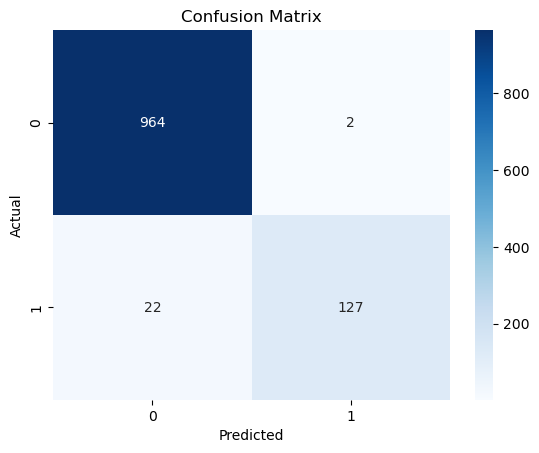

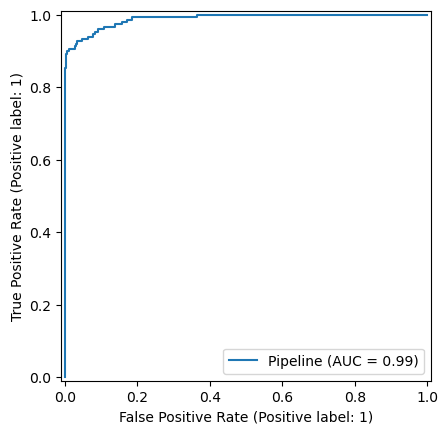

In [6]:
# Step 6: Evaluation
best_model = cv.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
f1 = classification_report(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"🎯 Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("\nClassification Report:\n", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

/tmp/ipykernel_932/422579815.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


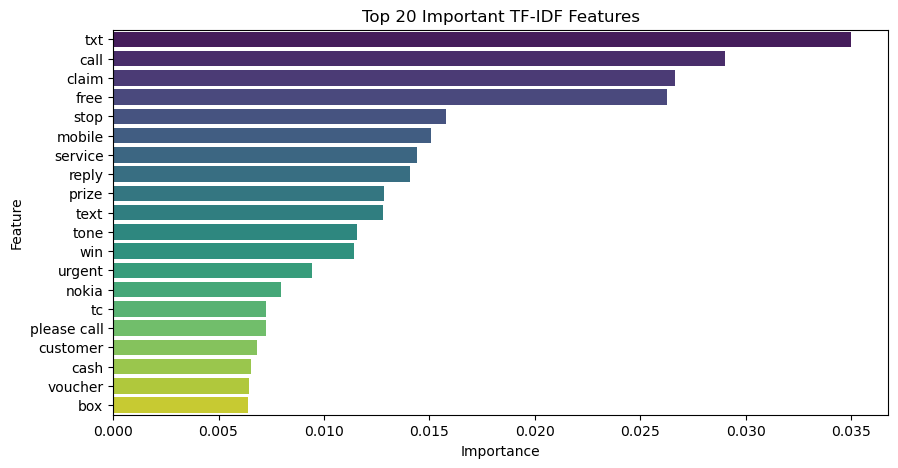

In [7]:
# Step 7: Feature Importance (TF-IDF top words)
rf_model = best_model.named_steps['rf']
feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()

importances = rf_model.feature_importances_[:len(feature_names)]
indices = np.argsort(importances)[-20:][::-1]

plt.figure(figsize=(10,5))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')
plt.title("Top 20 Important TF-IDF Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [8]:
# Step 8: Save model
joblib.dump(best_model, "random_forest_best.pkl")
print("✅ Model saved as random_forest_best.pkl")

✅ Model saved as random_forest_best.pkl
